In [4]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from skimage.segmentation import slic
from skimage import graph
from torch_geometric.data import Data, Batch  # Import Batch here
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
import matplotlib.pyplot as plt

# ... (rest of the code remains the same)


# Step 1: Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./mnist_data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./mnist_data', train=False, transform=transform, download=True)

# Dataloader for MNIST
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Function to convert image to superpixel graph
def image_to_graph(image, segments=75):
    # Step 2: Convert the image to superpixels
    image_np = image.squeeze().numpy()
    
    # Use slic for superpixel segmentation, specify channel_axis=None for grayscale
    superpixels = slic(image_np, n_segments=segments, compactness=0.1, start_label=0, channel_axis=None)

    # Step 3: Create Region Adjacency Graph (RAG)
    rag = graph.rag_mean_color(image_np, superpixels, mode='distance')

    # Get node features (average intensity of each superpixel)
    node_features = []
    for region in rag.nodes:
        mask = (superpixels == region)
        avg_intensity = np.mean(image_np[mask])
        node_features.append([avg_intensity])

    # Get edges from the RAG
    edge_index = []
    for edge in rag.edges:
        edge_index.append(edge)

    # Convert to PyTorch tensors
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create the graph data object
    graph_data = Data(x=node_features, edge_index=edge_index)

    return graph_data


# Rest of the code remains the same


# Step 4: Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Aggregate over nodes
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Step 5: Train and Test Functions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=1, hidden_dim=64, output_dim=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
def train(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # Convert each image to a graph
        graphs = []
        for image in images:
            graph = image_to_graph(image)
            graphs.append(graph)

        # Batch graphs together for GNN processing
        data_list = [g.to(device) for g in graphs]
        batch = torch_geometric.data.Batch.from_data_list(data_list)

        # Forward pass through the GNN
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, labels.to(device))

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == labels.to(device)).sum().item()

    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)
    return avg_loss, accuracy

# Testing loop
def test(model, test_loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):

            # Convert each image to a graph
            graphs = []
            for image in images:
                graph = image_to_graph(image)
                graphs.append(graph)

            # Batch graphs together for GNN processing
            data_list = [g.to(device) for g in graphs]
            batch = torch_geometric.data.Batch.from_data_list(data_list)

            # Forward pass through the GNN
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, labels.to(device))

            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == labels.to(device)).sum().item()

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return avg_loss, accuracy

# Step 6: Training the GNN Model
num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc = test(model, test_loader)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


NameError: name 'torch_geometric' is not defined

In [6]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from skimage.segmentation import slic
from skimage import graph
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np

# Step 1: Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./mnist_data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./mnist_data', train=False, transform=transform, download=True)

# Dataloader for MNIST
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Function to convert image to superpixel graph
def image_to_graph(image, segments=75):
    # Convert the image to superpixels
    image_np = image.squeeze().numpy()
    
    # Use slic for superpixel segmentation, specify channel_axis=None for grayscale
    superpixels = slic(image_np, n_segments=segments, compactness=0.1, start_label=0, channel_axis=None)

    # Create Region Adjacency Graph (RAG)
    rag = graph.rag_mean_color(image_np, superpixels, mode='distance')

    # Get node features (average intensity of each superpixel)
    node_features = []
    for region in rag.nodes:
        mask = (superpixels == region)
        avg_intensity = np.mean(image_np[mask])
        node_features.append([avg_intensity])

    # Get edges from the RAG
    edge_index = []
    for edge in rag.edges:
        edge_index.append(edge)

    # Convert to PyTorch tensors
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create the graph data object
    graph_data = Data(x=node_features, edge_index=edge_index)

    return graph_data

# Step 2: Define the GNN Model
class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.fc1 = torch.nn.Linear(32, 64)
        self.fc2 = torch.nn.Linear(64, 10)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Global pooling
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Training Function
def train(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in train_loader:
        optimizer.zero_grad()

        # Convert each image to a graph
        graphs = []
        for image in images:
            graph = image_to_graph(image)
            graphs.append(graph)

        # Batch graphs together for GNN processing
        data_list = [g.to(device) for g in graphs]
        batch = Batch.from_data_list(data_list)

        # Forward pass through the GNN
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.cross_entropy(out, labels.to(device))

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == labels.to(device)).sum().item()

    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)
    return avg_loss, accuracy

# Step 4: Testing Function
def test(model, test_loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            graphs = []
            for image in images:
                graph = image_to_graph(image)
                graphs.append(graph)

            data_list = [g.to(device) for g in graphs]
            batch = Batch.from_data_list(data_list)

            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.cross_entropy(out, labels.to(device))
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == labels.to(device)).sum().item()

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return avg_loss, accuracy

# Step 5: Main execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc = test(model, test_loader)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


Epoch 1, Train Loss: 0.0329, Train Acc: 0.2177, Test Loss: 0.0319, Test Acc: 0.2418
Epoch 2, Train Loss: 0.0318, Train Acc: 0.2431, Test Loss: 0.0318, Test Acc: 0.2455
Epoch 3, Train Loss: 0.0316, Train Acc: 0.2497, Test Loss: 0.0314, Test Acc: 0.2497
Epoch 4, Train Loss: 0.0311, Train Acc: 0.2542, Test Loss: 0.0308, Test Acc: 0.2579
Epoch 5, Train Loss: 0.0306, Train Acc: 0.2628, Test Loss: 0.0303, Test Acc: 0.2630


In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def image_to_graph(image, segments=75, plot_graph=False):
    # Convert the image to superpixels
    image_np = image.squeeze().numpy()

    # Use slic for superpixel segmentation, specify channel_axis=None for grayscale
    superpixels = slic(image_np, n_segments=segments, compactness=0.1, start_label=0, channel_axis=None)

    # Create Region Adjacency Graph (RAG)
    rag = graph.rag_mean_color(image_np, superpixels, mode='distance')

    # Get node features (average intensity of each superpixel)
    node_features = []
    for region in rag.nodes:
        mask = (superpixels == region)
        avg_intensity = np.mean(image_np[mask])
        node_features.append([avg_intensity])

    # Get edges from the RAG
    edge_index = []
    for edge in rag.edges:
        edge_index.append(edge)

    # Convert to PyTorch tensors
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create the graph data object
    graph_data = Data(x=node_features, edge_index=edge_index)

    # Visualize the graph if plot_graph is True
    if plot_graph:
        # Convert PyTorch Geometric graph to NetworkX for visualization
        G = to_networkx(graph_data, to_undirected=True)
        pos = nx.spring_layout(G)  # Layout for graph visualization

        # Plot the superpixels and graph
        plt.figure(figsize=(8, 8))

        # Plot the superpixels
        plt.subplot(1, 2, 1)
        plt.imshow(superpixels, cmap='gray')
        plt.title('Superpixels')

        # Plot the graph
        plt.subplot(1, 2, 2)
        nx.draw(G, pos, node_size=20, node_color='r', with_labels=False)
        plt.title('Graph Visualization')

        plt.show()

    return graph_data


Epoch 1, Train Loss: 0.0331, Train Acc: 0.2151, Test Loss: 0.0322, Test Acc: 0.2355
Epoch 2, Train Loss: 0.0321, Train Acc: 0.2399, Test Loss: 0.0321, Test Acc: 0.2419
Epoch 3, Train Loss: 0.0321, Train Acc: 0.2387, Test Loss: 0.0321, Test Acc: 0.2389
Epoch 4, Train Loss: 0.0321, Train Acc: 0.2400, Test Loss: 0.0322, Test Acc: 0.2390
Epoch 5, Train Loss: 0.0321, Train Acc: 0.2398, Test Loss: 0.0322, Test Acc: 0.2393


TypeError: '_AxesStack' object is not callable

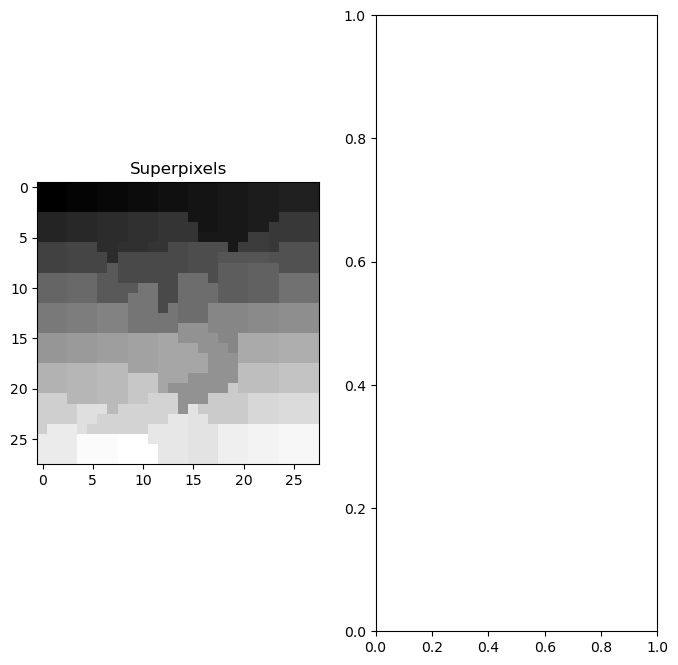

In [9]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from skimage.segmentation import slic
from skimage import graph
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Step 1: Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./mnist_data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./mnist_data', train=False, transform=transform, download=True)

# Dataloader for MNIST
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Function to convert image to superpixel graph and visualize it
def image_to_graph(image, segments=75, plot_graph=False):
    # Convert the image to superpixels
    image_np = image.squeeze().numpy()

    # Use slic for superpixel segmentation, specify channel_axis=None for grayscale
    superpixels = slic(image_np, n_segments=segments, compactness=0.1, start_label=0, channel_axis=None)

    # Create Region Adjacency Graph (RAG)
    rag = graph.rag_mean_color(image_np, superpixels, mode='distance')

    # Get node features (average intensity of each superpixel)
    node_features = []
    for region in rag.nodes:
        mask = (superpixels == region)
        avg_intensity = np.mean(image_np[mask])
        node_features.append([avg_intensity])

    # Get edges from the RAG
    edge_index = []
    for edge in rag.edges:
        edge_index.append(edge)

    # Convert to PyTorch tensors
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create the graph data object
    graph_data = Data(x=node_features, edge_index=edge_index)

    # Visualize the graph if plot_graph is True
    if plot_graph:
        # Convert PyTorch Geometric graph to NetworkX for visualization
        G = to_networkx(graph_data, to_undirected=True)
        pos = nx.spring_layout(G)  # Layout for graph visualization

        # Plot the superpixels and graph
        plt.figure(figsize=(8, 8))

        # Plot the superpixels
        plt.subplot(1, 2, 1)
        plt.imshow(superpixels, cmap='gray')
        plt.title('Superpixels')

        # Plot the graph
        plt.subplot(1, 2, 2)
        nx.draw(G, pos, node_size=20, node_color='r', with_labels=False)
        plt.title('Graph Visualization')

        plt.show()

    return graph_data

# Step 2: Define the GNN Model
class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.fc1 = torch.nn.Linear(32, 64)
        self.fc2 = torch.nn.Linear(64, 10)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Global pooling
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Training Function
def train(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in train_loader:
        optimizer.zero_grad()

        # Convert each image to a graph
        graphs = []
        for image in images:
            graph = image_to_graph(image)
            graphs.append(graph)

        # Batch graphs together for GNN processing
        data_list = [g.to(device) for g in graphs]
        batch = Batch.from_data_list(data_list)

        # Forward pass through the GNN
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.cross_entropy(out, labels.to(device))

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == labels.to(device)).sum().item()

    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)
    return avg_loss, accuracy

# Step 4: Testing Function
def test(model, test_loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            graphs = []
            for image in images:
                graph = image_to_graph(image)
                graphs.append(graph)

            data_list = [g.to(device) for g in graphs]
            batch = Batch.from_data_list(data_list)

            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.cross_entropy(out, labels.to(device))
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == labels.to(device)).sum().item()

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return avg_loss, accuracy

# Step 5: Main execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc = test(model, test_loader)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Step 6: Visualize graph for an example image
image, label = mnist_train[0]  # Get the first image from the training set
graph_data = image_to_graph(image, plot_graph=True)  # Plot the graph


In [10]:
!pip install torch torchvision torch-geometric scikit-image networkx matplotlib



Epoch 1, Train Loss: 0.0329, Train Acc: 0.2235, Test Loss: 0.0321, Test Acc: 0.2390
Epoch 2, Train Loss: 0.0321, Train Acc: 0.2392, Test Loss: 0.0321, Test Acc: 0.2352
Epoch 3, Train Loss: 0.0321, Train Acc: 0.2394, Test Loss: 0.0322, Test Acc: 0.2413
Epoch 4, Train Loss: 0.0321, Train Acc: 0.2394, Test Loss: 0.0321, Test Acc: 0.2410
Epoch 5, Train Loss: 0.0321, Train Acc: 0.2402, Test Loss: 0.0321, Test Acc: 0.2414


TypeError: '_AxesStack' object is not callable

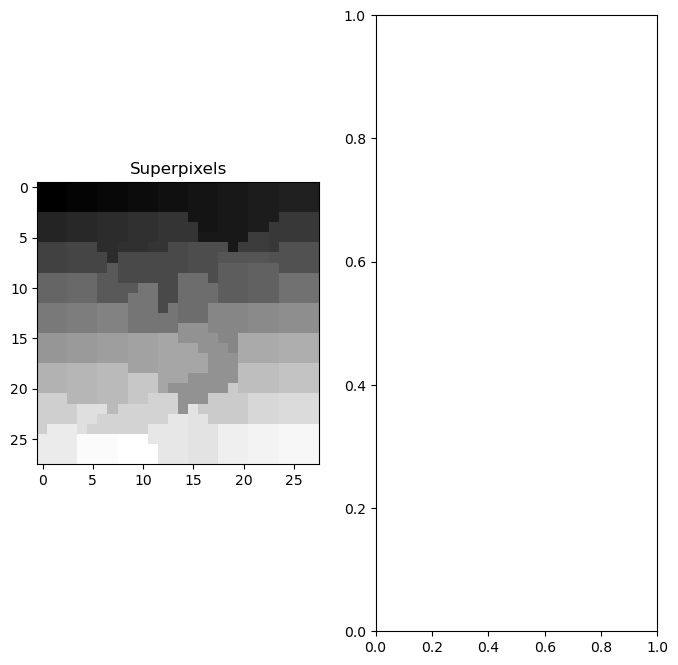

In [11]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from skimage.segmentation import slic
from skimage import graph
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Step 1: Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./mnist_data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./mnist_data', train=False, transform=transform, download=True)

# Dataloader for MNIST
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Function to convert image to superpixel graph and visualize it
def image_to_graph(image, segments=75, plot_graph=False):
    # Convert the image to superpixels
    image_np = image.squeeze().numpy()

    # Use slic for superpixel segmentation, specify channel_axis=None for grayscale
    superpixels = slic(image_np, n_segments=segments, compactness=0.1, start_label=0, channel_axis=None)

    # Create Region Adjacency Graph (RAG)
    rag = graph.rag_mean_color(image_np, superpixels, mode='distance')

    # Get node features (average intensity of each superpixel)
    node_features = []
    for region in rag.nodes:
        mask = (superpixels == region)
        avg_intensity = np.mean(image_np[mask])
        node_features.append([avg_intensity])

    # Get edges from the RAG
    edge_index = []
    for edge in rag.edges:
        edge_index.append(edge)

    # Convert to PyTorch tensors
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create the graph data object
    graph_data = Data(x=node_features, edge_index=edge_index)

    # Visualize the graph if plot_graph is True
    if plot_graph:
        # Convert PyTorch Geometric graph to NetworkX for visualization
        G = to_networkx(graph_data, to_undirected=True)
        pos = nx.spring_layout(G)  # Layout for graph visualization

        # Plot the superpixels and graph
        plt.figure(figsize=(8, 8))

        # Plot the superpixels
        plt.subplot(1, 2, 1)
        plt.imshow(superpixels, cmap='gray')
        plt.title('Superpixels')

        # Plot the graph
        plt.subplot(1, 2, 2)
        nx.draw(G, pos, node_size=20, node_color='r', with_labels=False)
        plt.title('Graph Visualization')

        plt.show()

    return graph_data

# Step 2: Define the GNN Model
class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.fc1 = torch.nn.Linear(32, 64)
        self.fc2 = torch.nn.Linear(64, 10)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Global pooling
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Training Function
def train(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in train_loader:
        optimizer.zero_grad()

        # Convert each image to a graph
        graphs = []
        for image in images:
            graph = image_to_graph(image)
            graphs.append(graph)

        # Batch graphs together for GNN processing
        data_list = [g.to(device) for g in graphs]
        batch = Batch.from_data_list(data_list)

        # Forward pass through the GNN
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.cross_entropy(out, labels.to(device))

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == labels.to(device)).sum().item()

    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)
    return avg_loss, accuracy

# Step 4: Testing Function
def test(model, test_loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            graphs = []
            for image in images:
                graph = image_to_graph(image)
                graphs.append(graph)

            data_list = [g.to(device) for g in graphs]
            batch = Batch.from_data_list(data_list)

            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.cross_entropy(out, labels.to(device))
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == labels.to(device)).sum().item()

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return avg_loss, accuracy

# Step 5: Main execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc = test(model, test_loader)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Step 6: Visualize graph for an example image
image, label = mnist_train[0]  # Get the first image from the training set
graph_data = image_to_graph(image, plot_graph=True)  # Plot the graph


Epoch 1, Train Loss: 0.0330, Train Acc: 0.2174, Test Loss: 0.0322, Test Acc: 0.2416


C:\Users\Sashwat Shukla\AppData\Local\Temp\ipykernel_17024\1122979143.py:63: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


AttributeError: 'NoneType' object has no attribute 'set_facecolor'

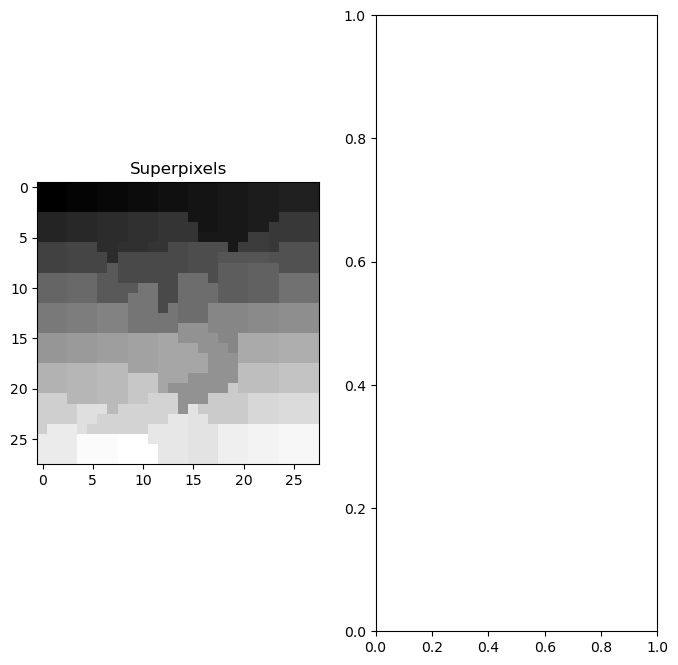

In [12]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from skimage.segmentation import slic
from skimage import graph
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Step 1: Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./mnist_data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./mnist_data', train=False, transform=transform, download=True)

# Dataloader for MNIST
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Function to convert image to superpixel graph and visualize it
def image_to_graph(image, segments=75, plot_graph=False):
    # Convert the image to superpixels
    image_np = image.squeeze().numpy()

    # Use slic for superpixel segmentation, specify channel_axis=None for grayscale
    superpixels = slic(image_np, n_segments=segments, compactness=0.1, start_label=0, channel_axis=None)

    # Create Region Adjacency Graph (RAG)
    rag = graph.rag_mean_color(image_np, superpixels, mode='distance')

    # Get node features (average intensity of each superpixel)
    node_features = []
    for region in rag.nodes:
        mask = (superpixels == region)
        avg_intensity = np.mean(image_np[mask])
        node_features.append([avg_intensity])

    # Get edges from the RAG
    edge_index = []
    for edge in rag.edges:
        edge_index.append(edge)

    # Convert to PyTorch tensors
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create the graph data object
    graph_data = Data(x=node_features, edge_index=edge_index)

    # Visualize the graph if plot_graph is True
    if plot_graph:
        # Convert PyTorch Geometric graph to NetworkX for visualization
        G = to_networkx(graph_data, to_undirected=True)
        pos = nx.spring_layout(G)  # Layout for graph visualization

        # Create a new figure explicitly and add a subplot
        fig, ax = plt.subplots(figsize=(8, 8))

        # Plot the superpixels
        plt.subplot(1, 2, 1)
        plt.imshow(superpixels, cmap='gray')
        plt.title('Superpixels')

        # Plot the graph on a new axis
        plt.subplot(1, 2, 2)
        nx.draw(G, pos, node_size=20, node_color='r', with_labels=False, ax=ax)  # Use ax for axis control
        plt.title('Graph Visualization')

        plt.show()

    return graph_data

# Step 2: Define the GNN Model
class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        self.fc1 = torch.nn.Linear(32, 64)
        self.fc2 = torch.nn.Linear(64, 10)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Global pooling
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Training Function
def train(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in train_loader:
        optimizer.zero_grad()

        # Convert each image to a graph
        graphs = []
        for image in images:
            graph = image_to_graph(image)
            graphs.append(graph)

        # Batch graphs together for GNN processing
        data_list = [g.to(device) for g in graphs]
        batch = Batch.from_data_list(data_list)

        # Forward pass through the GNN
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.cross_entropy(out, labels.to(device))

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == labels.to(device)).sum().item()

    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)
    return avg_loss, accuracy

# Step 4: Testing Function
def test(model, test_loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            graphs = []
            for image in images:
                graph = image_to_graph(image)
                graphs.append(graph)

            data_list = [g.to(device) for g in graphs]
            batch = Batch.from_data_list(data_list)

            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.cross_entropy(out, labels.to(device))
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == labels.to(device)).sum().item()

    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return avg_loss, accuracy

# Step 5: Main execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc = test(model, test_loader)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Step 6: Visualize graph for an example image
image, label = mnist_train[0]  # Get the first image from the training set
graph_data = image_to_graph(image, plot_graph=True)  # Plot the graph


Epoch 1, Train Loss: 0.0327, Train Acc: 0.2221, Test Loss: 0.0324, Test Acc: 0.2287
Epoch 2, Train Loss: 0.0323, Train Acc: 0.2347, Test Loss: 0.0323, Test Acc: 0.2390
Epoch 3, Train Loss: 0.0323, Train Acc: 0.2361, Test Loss: 0.0323, Test Acc: 0.2316
Epoch 4, Train Loss: 0.0323, Train Acc: 0.2345, Test Loss: 0.0325, Test Acc: 0.2255
Epoch 5, Train Loss: 0.0323, Train Acc: 0.2360, Test Loss: 0.0323, Test Acc: 0.2327


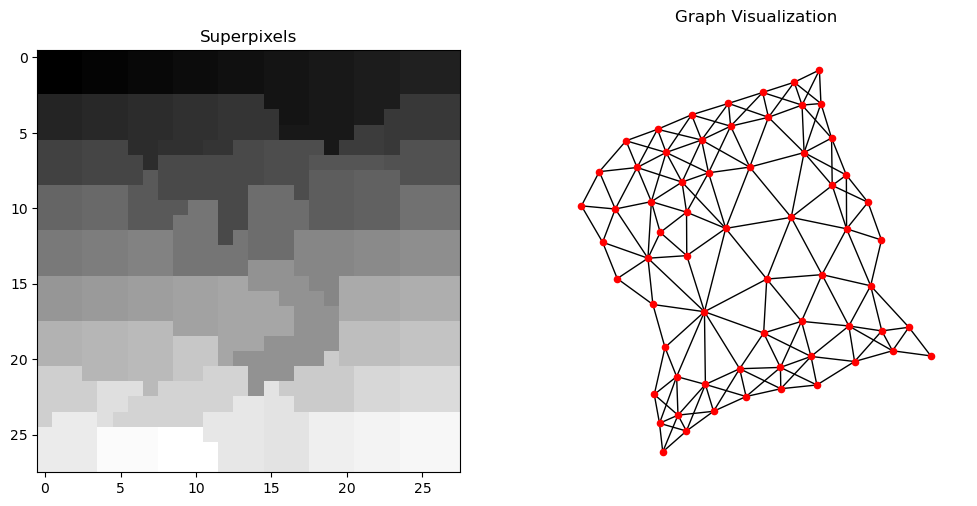

In [18]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skimage.segmentation import slic
from skimage import graph  # Corrected import
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data, Batch  # Import Batch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_networkx
import numpy as np

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Function to Convert Image to Superpixel Graph
def image_to_graph(image, segments=75, plot_graph=False):
    # Convert the image to superpixels
    image_np = image.squeeze().numpy()

    # Use slic for superpixel segmentation, specify channel_axis=None for grayscale
    superpixels = slic(image_np, n_segments=segments, compactness=0.1, start_label=0, channel_axis=None)

    # Create Region Adjacency Graph (RAG)
    rag = graph.rag_mean_color(image_np, superpixels, mode='distance')

    # Get node features (average intensity of each superpixel)
    node_features = []
    for region in rag.nodes:
        mask = (superpixels == region)
        avg_intensity = np.mean(image_np[mask])
        node_features.append([avg_intensity])

    # Get edges from the RAG
    edge_index = []
    for edge in rag.edges:
        edge_index.append(edge)

    # Convert to PyTorch tensors
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create the graph data object
    graph_data = Data(x=node_features, edge_index=edge_index)

    # Visualize the graph if plot_graph is True
    if plot_graph:
        # Convert PyTorch Geometric graph to NetworkX for visualization
        G = to_networkx(graph_data, to_undirected=True)
        pos = nx.spring_layout(G)  # Layout for graph visualization

        # Create a new figure for visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Plot the superpixels
        ax1.imshow(superpixels, cmap='gray')
        ax1.set_title('Superpixels')

        # Plot the graph on a new axis
        nx.draw(G, pos, node_size=20, node_color='r', with_labels=False, ax=ax2)  # Use ax2 for axis control
        ax2.set_title('Graph Visualization')

        plt.show()

    return graph_data

# Define the GNN Model
class GNNModel(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNModel, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 10)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        # Global mean pooling (graph-level readout)
        x = global_mean_pool(x, batch)

        # Apply a final classifier
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

# DataLoader and Training Setup
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0

    for images, labels in loader:
        optimizer.zero_grad()

        graphs = []
        for image in images:
            graph = image_to_graph(image)
            graphs.append(graph)

        data_list = [g.to(device) for g in graphs]
        batch = Batch.from_data_list(data_list)

        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.nll_loss(out, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += out.argmax(dim=1).eq(labels).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def test(model, loader):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for images, labels in loader:
            graphs = []
            for image in images:
                graph = image_to_graph(image)
                graphs.append(graph)

            data_list = [g.to(device) for g in graphs]
            batch = Batch.from_data_list(data_list)

            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.nll_loss(out, labels)

            total_loss += loss.item()
            correct += out.argmax(dim=1).eq(labels).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Set device and hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel(hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Prepare DataLoader
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc = test(model, test_loader)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Step 6: Visualize graph for an example image
image, label = mnist_train[0]  # Get the first image from the training set
graph_data = image_to_graph(image, plot_graph=True)


In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torchvision import datasets, transforms
from skimage.segmentation import slic+
from skimage import graph
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch.nn as nn

# Define the model with added layers, dropout, and batch normalization
class GNNModel(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNModel, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(1, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)  # Additional layer
        self.bn3 = nn.BatchNorm1d(hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv3(x, edge_index)  # Additional layer
        x = self.bn3(x)
        x = global_mean_pool(x, batch)
        
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

# Graph creation function with visualization
def image_to_graph(image, segments=100, plot_graph=False):
    image_np = image.squeeze().numpy()
    superpixels = slic(image_np, n_segments=segments, compactness=0.1, start_label=0)
    rag = graph.rag_mean_color(image_np, superpixels, mode='distance')
    G = nx.Graph()

    for (i, j, d) in rag.edges(data=True):
        G.add_edge(i, j, weight=d['weight'])
    
    x = np.array([np.mean(image_np[superpixels == i]) for i in range(superpixels.max() + 1)])
    x = torch.tensor(x, dtype=torch.float).view(-1, 1)
    
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    edge_weight = torch.tensor([G[u][v]['weight'] for u, v in G.edges], dtype=torch.float)
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)
    
    if plot_graph:
        pos = nx.spring_layout(G)
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image_np, cmap='gray')
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        nx.draw(G, pos, node_size=20, node_color='r', with_labels=False)
        plt.title('Graph Visualization')
        plt.show()

    return data

# Load the dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root=".", train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root=".", train=False, transform=transform, download=True)

# Data loaders
def collate_fn(batch):
    graphs = [image_to_graph(image) for image, _ in batch]
    labels = torch.tensor([label for _, label in batch], dtype=torch.long)
    return graphs, labels

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Define training and testing functions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel(hidden_channels=32).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)

def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for graphs, labels in loader:
        data_list = [g.to(device) for g in graphs]
        batch = torch_geometric.data.Batch.from_data_list(data_list)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.nll_loss(out, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == labels).sum().item()
    
    return total_loss / len(loader), correct / len(loader.dataset)

def test(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for graphs, labels in loader:
            data_list = [g.to(device) for g in graphs]
            batch = torch_geometric.data.Batch.from_data_list(data_list)
            labels = labels.to(device)
            
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.nll_loss(out, labels)
            
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == labels).sum().item()
    
    return total_loss / len(loader), correct / len(loader.dataset)

# Training loop with scheduler
num_epochs = 20
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc = test(model, test_loader)
    
    scheduler.step()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Visualization of the graph for a sample image
image, label = mnist_train[0]
graph_data = image_to_graph(image, plot_graph=True)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

C:\Users\Sashwat Shukla\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1002)>



100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:06<00:00, 1.60MB/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1002)>



100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 108kB/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1002)>



100%|██████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:02<00:00, 566kB/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1002)>



100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.68MB/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw

Epoch 1, Train Loss: 0.0327, Train Acc: 0.2221, Test Loss: 0.0324, Test Acc: 0.2287
Epoch 2, Train Loss: 0.0323, Train Acc: 0.2347, Test Loss: 0.0323, Test Acc: 0.2390
Epoch 3, Train Loss: 0.0323, Train Acc: 0.2361, Test Loss: 0.0323, Test Acc: 0.2316
Epoch 4, Train Loss: 0.0323, Train Acc: 0.2345, Test Loss: 0.0325, Test Acc: 0.2255
Epoch 5, Train Loss: 0.0323, Train Acc: 0.2360, Test Loss: 0.0323, Test Acc: 0.2327


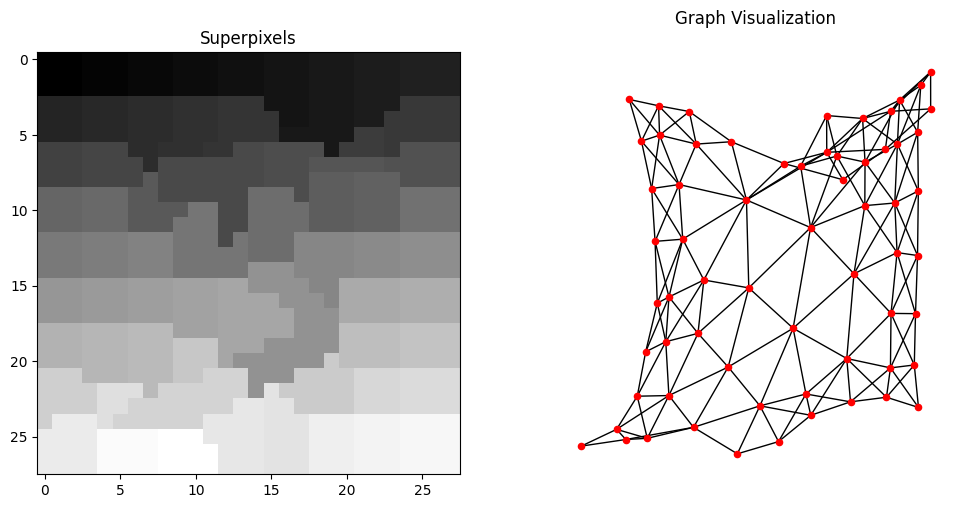

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skimage.segmentation import slic
from skimage import graph  # Corrected import
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data, Batch  # Import Batch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_networkx
import numpy as np

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Function to Convert Image to Superpixel Graph
def image_to_graph(image, segments=75, plot_graph=False):
    # Convert the image to superpixels
    image_np = image.squeeze().numpy()

    # Use slic for superpixel segmentation, specify channel_axis=None for grayscale
    superpixels = slic(image_np, n_segments=segments, compactness=0.1, start_label=0, channel_axis=None)

    # Create Region Adjacency Graph (RAG)
    rag = graph.rag_mean_color(image_np, superpixels, mode='distance')

    # Get node features (average intensity of each superpixel)
    node_features = []
    for region in rag.nodes:
        mask = (superpixels == region)
        avg_intensity = np.mean(image_np[mask])
        node_features.append([avg_intensity])

    # Get edges from the RAG
    edge_index = []
    for edge in rag.edges:
        edge_index.append(edge)

    # Convert to PyTorch tensors
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create the graph data object
    graph_data = Data(x=node_features, edge_index=edge_index)

    # Visualize the graph if plot_graph is True
    if plot_graph:
        # Convert PyTorch Geometric graph to NetworkX for visualization
        G = to_networkx(graph_data, to_undirected=True)
        pos = nx.spring_layout(G)  # Layout for graph visualization

        # Create a new figure for visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Plot the superpixels
        ax1.imshow(superpixels, cmap='gray')
        ax1.set_title('Superpixels')

        # Plot the graph on a new axis
        nx.draw(G, pos, node_size=20, node_color='r', with_labels=False, ax=ax2)  # Use ax2 for axis control
        ax2.set_title('Graph Visualization')

        plt.show()

    return graph_data

# Define the GNN Model
class GNNModel(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNModel, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 10)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        # Global mean pooling (graph-level readout)
        x = global_mean_pool(x, batch)

        # Apply a final classifier
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

# DataLoader and Training Setup
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0

    for images, labels in loader:
        optimizer.zero_grad()

        graphs = []
        for image in images:
            graph = image_to_graph(image)
            graphs.append(graph)

        data_list = [g.to(device) for g in graphs]
        batch = Batch.from_data_list(data_list)

        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.nll_loss(out, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += out.argmax(dim=1).eq(labels).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def test(model, loader):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for images, labels in loader:
            graphs = []
            for image in images:
                graph = image_to_graph(image)
                graphs.append(graph)

            data_list = [g.to(device) for g in graphs]
            batch = Batch.from_data_list(data_list)

            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.nll_loss(out, labels)

            total_loss += loss.item()
            correct += out.argmax(dim=1).eq(labels).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Set device and hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel(hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Prepare DataLoader
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc = test(model, test_loader)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Step 6: Visualize graph for an example image
image, label = mnist_train[0]  # Get the first image from the training set
graph_data = image_to_graph(image, plot_graph=True)

Epoch 1, Train Loss: 0.0327, Train Acc: 0.2221, Test Loss: 0.0324, Test Acc: 0.2287
Epoch 2, Train Loss: 0.0323, Train Acc: 0.2347, Test Loss: 0.0323, Test Acc: 0.2390
Epoch 3, Train Loss: 0.0323, Train Acc: 0.2361, Test Loss: 0.0323, Test Acc: 0.2316
Epoch 4, Train Loss: 0.0323, Train Acc: 0.2345, Test Loss: 0.0325, Test Acc: 0.2255
Epoch 5, Train Loss: 0.0323, Train Acc: 0.2360, Test Loss: 0.0323, Test Acc: 0.2327
Epoch 6, Train Loss: 0.0323, Train Acc: 0.2354, Test Loss: 0.0323, Test Acc: 0.2369
Epoch 7, Train Loss: 0.0323, Train Acc: 0.2340, Test Loss: 0.0324, Test Acc: 0.2312
Epoch 8, Train Loss: 0.0323, Train Acc: 0.2359, Test Loss: 0.0323, Test Acc: 0.2326
Epoch 9, Train Loss: 0.0318, Train Acc: 0.2454, Test Loss: 0.0317, Test Acc: 0.2432
Epoch 10, Train Loss: 0.0300, Train Acc: 0.2842, Test Loss: 0.0297, Test Acc: 0.2892
Epoch 11, Train Loss: 0.0297, Train Acc: 0.2890, Test Loss: 0.0296, Test Acc: 0.2855
Epoch 12, Train Loss: 0.0296, Train Acc: 0.2917, Test Loss: 0.0293, Test A

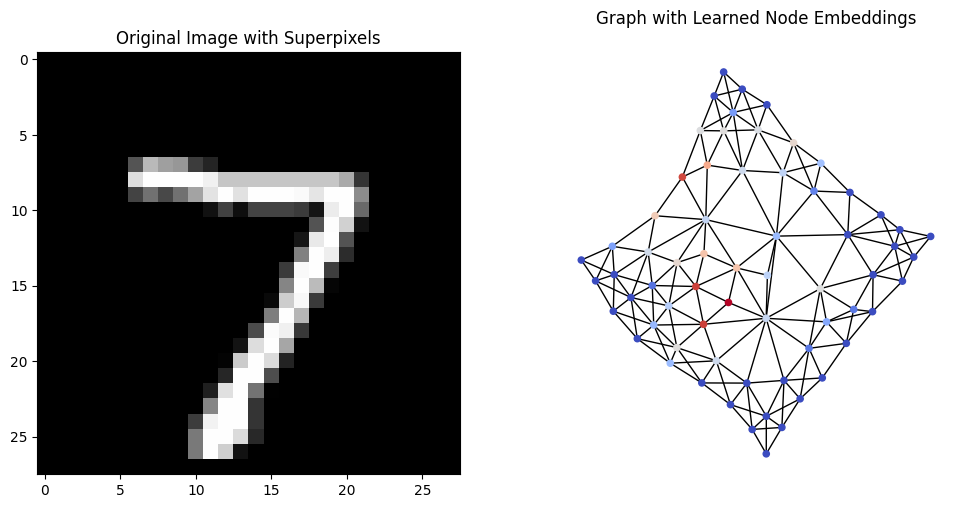

In [4]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skimage.segmentation import slic
from skimage import graph
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_networkx
import numpy as np

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Function to Convert Image to Superpixel Graph
def image_to_graph(image, segments=75, plot_graph=False):
    image_np = image.squeeze().numpy()
    superpixels = slic(image_np, n_segments=segments, compactness=0.1, start_label=0, channel_axis=None)
    rag = graph.rag_mean_color(image_np, superpixels, mode='distance')

    node_features = []
    for region in rag.nodes:
        mask = (superpixels == region)
        avg_intensity = np.mean(image_np[mask])
        node_features.append([avg_intensity])

    edge_index = []
    for edge in rag.edges:
        edge_index.append(edge)

    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    graph_data = Data(x=node_features, edge_index=edge_index)

    if plot_graph:
        G = to_networkx(graph_data, to_undirected=True)
        pos = nx.spring_layout(G)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(superpixels, cmap='gray')
        ax1.set_title('Superpixels')
        nx.draw(G, pos, node_size=20, node_color='r', with_labels=False, ax=ax2)
        ax2.set_title('Graph Visualization')
        plt.show()

    return graph_data

# Define the GNN Model
class GNNModel(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNModel, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 10)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

# Training and testing functions
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in loader:
        optimizer.zero_grad()
        graphs = [image_to_graph(image) for image in images]
        data_list = [g.to(device) for g in graphs]
        batch = Batch.from_data_list(data_list)
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.nll_loss(out, labels.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += out.argmax(dim=1).eq(labels.to(device)).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def test(model, loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            graphs = [image_to_graph(image) for image in images]
            data_list = [g.to(device) for g in graphs]
            batch = Batch.from_data_list(data_list)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.nll_loss(out, labels.to(device))
            total_loss += loss.item()
            correct += out.argmax(dim=1).eq(labels.to(device)).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Function to visualize the graph after training
def visualize_learned_graph(model, dataset, device, segments=75):
    model.eval()
    image, label = dataset[0]
    graph_data = image_to_graph(image, segments=segments, plot_graph=False).to(device)

    with torch.no_grad():
        x = model.conv1(graph_data.x, graph_data.edge_index)
        x = x.relu()
        x = model.conv2(x, graph_data.edge_index)
    
    G = to_networkx(Data(x=x, edge_index=graph_data.edge_index), to_undirected=True)
    pos = nx.spring_layout(G)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image.squeeze().numpy(), cmap='gray')
    ax1.set_title('Original Image with Superpixels')
    
    node_colors = x.cpu().numpy()[:, 0]
    nx.draw(G, pos, node_size=20, node_color=node_colors, cmap='coolwarm', ax=ax2)
    ax2.set_title('Graph with Learned Node Embeddings')
    plt.show()

# Main training and visualization
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GNNModel(hidden_channels=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

    num_epochs = 50
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, device)
        test_loss, test_acc = test(model, test_loader, device)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    # Visualize the learned graph structure after training
    visualize_learned_graph(model, mnist_test, device)


Epoch 1, Train Loss: 0.0327, Train Acc: 0.2221, Test Loss: 0.0324, Test Acc: 0.2287
Epoch 2, Train Loss: 0.0323, Train Acc: 0.2347, Test Loss: 0.0323, Test Acc: 0.2390
Epoch 3, Train Loss: 0.0323, Train Acc: 0.2361, Test Loss: 0.0323, Test Acc: 0.2316
Epoch 4, Train Loss: 0.0323, Train Acc: 0.2345, Test Loss: 0.0325, Test Acc: 0.2255
Epoch 5, Train Loss: 0.0323, Train Acc: 0.2360, Test Loss: 0.0323, Test Acc: 0.2327


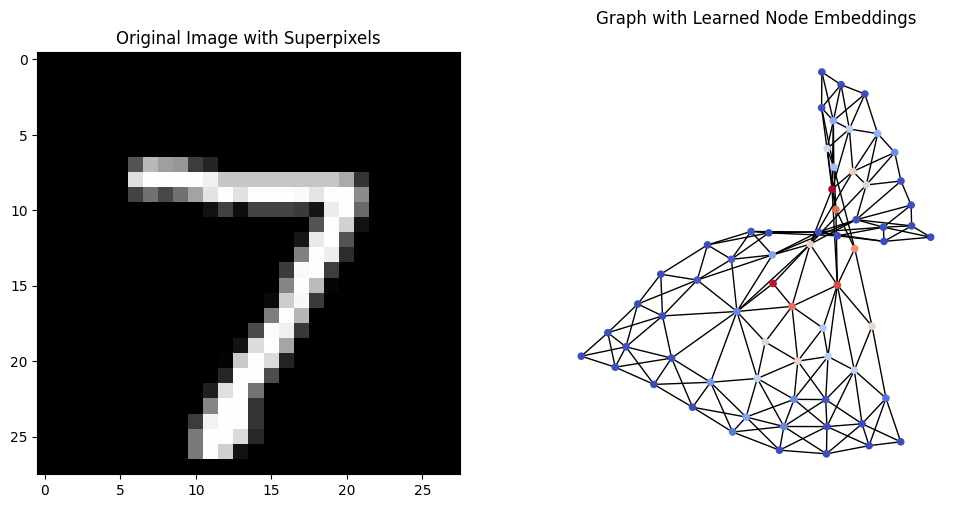

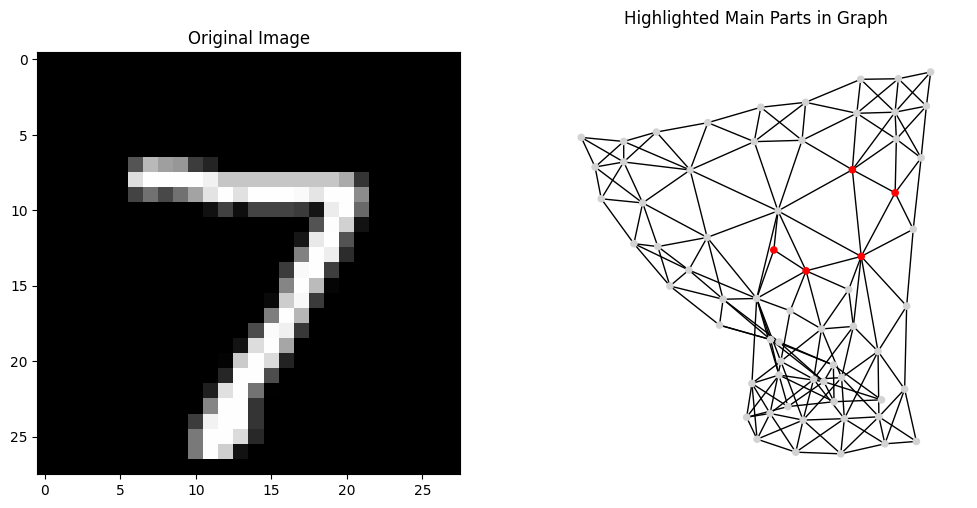

In [3]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skimage.segmentation import slic
from skimage import graph
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import to_networkx
import numpy as np

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Function to Convert Image to Superpixel Graph
def image_to_graph(image, segments=75, plot_graph=False):
    image_np = image.squeeze().numpy()
    superpixels = slic(image_np, n_segments=segments, compactness=0.1, start_label=0, channel_axis=None)
    rag = graph.rag_mean_color(image_np, superpixels, mode='distance')

    node_features = []
    for region in rag.nodes:
        mask = (superpixels == region)
        avg_intensity = np.mean(image_np[mask])
        node_features.append([avg_intensity])

    edge_index = []
    for edge in rag.edges:
        edge_index.append(edge)

    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    graph_data = Data(x=node_features, edge_index=edge_index)

    if plot_graph:
        G = to_networkx(graph_data, to_undirected=True)
        pos = nx.spring_layout(G)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(superpixels, cmap='gray')
        ax1.set_title('Superpixels')
        nx.draw(G, pos, node_size=20, node_color='r', with_labels=False, ax=ax2)
        ax2.set_title('Graph Visualization')
        plt.show()

    return graph_data

# Define the GNN Model
class GNNModel(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNModel, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 10)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

# Training and testing functions
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in loader:
        optimizer.zero_grad()
        graphs = [image_to_graph(image) for image in images]
        data_list = [g.to(device) for g in graphs]
        batch = Batch.from_data_list(data_list)
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.nll_loss(out, labels.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += out.argmax(dim=1).eq(labels.to(device)).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def test(model, loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            graphs = [image_to_graph(image) for image in images]
            data_list = [g.to(device) for g in graphs]
            batch = Batch.from_data_list(data_list)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = F.nll_loss(out, labels.to(device))
            total_loss += loss.item()
            correct += out.argmax(dim=1).eq(labels.to(device)).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Function to visualize the graph after training
def visualize_learned_graph(model, dataset, device, segments=75):
    model.eval()
    image, label = dataset[0]
    graph_data = image_to_graph(image, segments=segments, plot_graph=False).to(device)

    with torch.no_grad():
        x = model.conv1(graph_data.x, graph_data.edge_index)
        x = x.relu()
        x = model.conv2(x, graph_data.edge_index)
    
    G = to_networkx(Data(x=x, edge_index=graph_data.edge_index), to_undirected=True)
    pos = nx.spring_layout(G)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image.squeeze().numpy(), cmap='gray')
    ax1.set_title('Original Image with Superpixels')
    
    node_colors = x.cpu().numpy()[:, 0]
    nx.draw(G, pos, node_size=20, node_color=node_colors, cmap='coolwarm', ax=ax2)
    ax2.set_title('Graph with Learned Node Embeddings')
    plt.show()

# Function to highlight the main part of the image based on node embeddings
def highlight_main_part(model, dataset, device, segments=75, threshold=0.5):
    model.eval()
    image, label = dataset[0]
    graph_data = image_to_graph(image, segments=segments, plot_graph=False).to(device)

    with torch.no_grad():
        x = model.conv1(graph_data.x, graph_data.edge_index)
        x = x.relu()
        x = model.conv2(x, graph_data.edge_index)

    # Filter the main parts based on a threshold in the learned node embeddings
    main_parts = x[:, 0] > threshold  # Select nodes with high activation

    G = to_networkx(Data(x=x, edge_index=graph_data.edge_index), to_undirected=True)
    pos = nx.spring_layout(G)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image.squeeze().numpy(), cmap='gray')
    ax1.set_title('Original Image')

    # Color nodes based on main parts (highlighted in red)
    node_colors = ['red' if main_parts[i] else 'lightgrey' for i in range(x.size(0))]
    nx.draw(G, pos, node_size=20, node_color=node_colors, ax=ax2)
    ax2.set_title('Highlighted Main Parts in Graph')
    plt.show()

# Main training and visualization
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GNNModel(hidden_channels=16).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

    num_epochs = 5
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, device)
        test_loss, test_acc = test(model, test_loader, device)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    # Visualize the learned graph structure after training
    visualize_learned_graph(model, mnist_test, device)
    
    # Highlight the main part of the image based on node activations after training
    highlight_main_part(model, mnist_test, device)


In [3]:
!pip install --upgrade numpy
!pip install --upgrade scikit-learn


                                              0.0/11.0 MB ? eta -:--:--
     -                                        0.4/11.0 MB 8.9 MB/s eta 0:00:02
     ---                                      1.0/11.0 MB 10.2 MB/s eta 0:00:01
     -----                                    1.5/11.0 MB 10.5 MB/s eta 0:00:01
     -------                                  2.0/11.0 MB 10.7 MB/s eta 0:00:01
     ---------                                2.5/11.0 MB 10.9 MB/s eta 0:00:01
     -----------                              3.1/11.0 MB 10.6 MB/s eta 0:00:01
     --------------                           3.9/11.0 MB 11.3 MB/s eta 0:00:01
     ---------------                          4.4/11.0 MB 11.2 MB/s eta 0:00:01
     -----------------                        4.9/11.0 MB 11.2 MB/s eta 0:00:01
     -------------------                      5.5/11.0 MB 11.3 MB/s eta 0:00:01
     ---------------------                    5.9/11.0 MB 11.1 MB/s eta 0:00:01
     -----------------------                  6.3